In [26]:
import streamlit as st
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import plotly.express as px
import numpy as np

df1 = pd.read_csv('/Users/toby/STADS_Datathon2025/disease_prevelance_simple.csv', sep=',')
print(df1.columns)
# Load the second CSV file (using semicolon as the separator)
df2 = pd.read_csv('/Users/toby/STADS_Datathon2025/20025-03-07_cgm-datathon-challenge-flu_riskgroupsv1.csv', sep=';')
print(df2.columns)
# Merge the two DataFrames on 'Disease' from df2 and 'risk_groups' from df1 using an outer join
merged_df = pd.merge(df1, df2, left_on='Disease', right_on='risk_groups', how='outer')

merged_df = merged_df.drop(columns=['Unnamed: 0'])




Index(['Unnamed: 0', 'Disease', 'Prevelance'], dtype='object')
Index(['week', 'kvregion', 'region', 'specialization', 'gender', 'age_group',
       'insurancecode', 'insurancetype', 'risk_groups', 'absolute',
       'extrapolated'],
      dtype='object')


In [27]:
merged_df.columns

Index(['Disease', 'Prevelance', 'week', 'kvregion', 'region', 'specialization',
       'gender', 'age_group', 'insurancecode', 'insurancetype', 'risk_groups',
       'absolute', 'extrapolated'],
      dtype='object')

In [28]:
df = merged_df.copy()

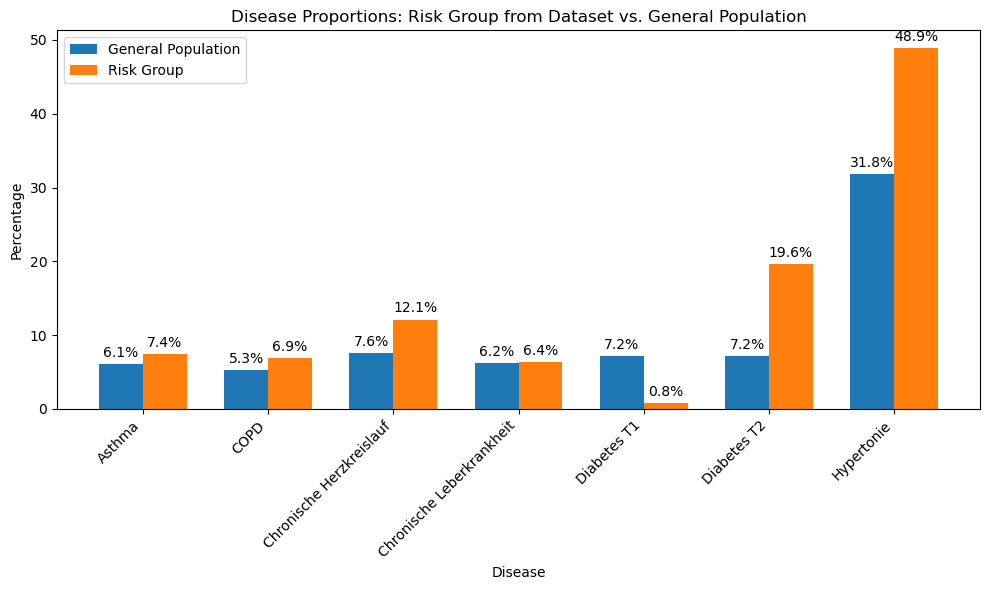

In [45]:
# --- Data Aggregation ---
# Group by 'Disease' and calculate the mean for each percentage column.
agg_df = df.groupby("risk_groups").agg({
    "Prevelance": "mean",      # General population prevalence
    "extrapolated": "sum"       # Risk group proportion
}).reset_index()

# --- Plotting Setup ---
# Create the x-axis positions for each disease.
x = np.arange(len(agg_df["risk_groups"]))  # one position per disease
width = 0.35  # width of each bar

# Create the figure and axis.
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for general population prevalence.
bars1 = ax.bar(x - width/2, agg_df["Prevelance"], width, label="General Population")

# Plot bars for risk group proportions.
bars2 = ax.bar(x + width/2, agg_df["extrapolated"]/len(df), width, label="Risk Group")

# --- Customizing the Plot ---
ax.set_xlabel("Disease")
ax.set_ylabel("Percentage")
ax.set_title("Disease Proportions: Risk Group from Dataset vs. General Population")
ax.set_xticks(x)
ax.set_xticklabels(agg_df["risk_groups"], rotation=45, ha="right")
ax.legend()

# Optionally, annotate each bar with its height.
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

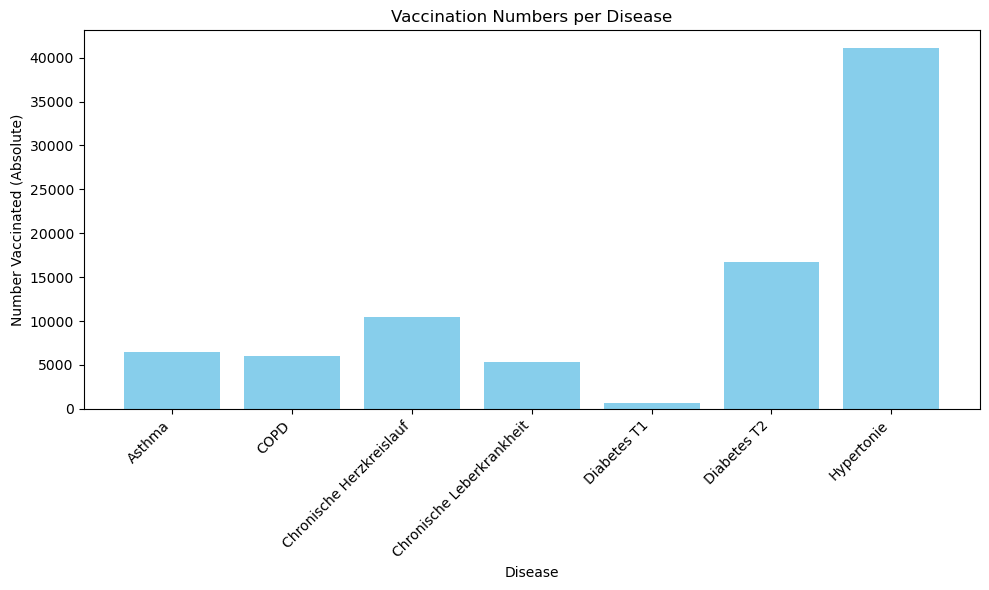

In [30]:
# Assume df is your DataFrame with columns:
# ['risk_groups', 'absolute', ... ]

# Optional: Aggregate data in case there are multiple rows per disease.
# Here, we sum the "absolute" counts per risk group (disease).
agg_df = df.groupby("risk_groups")["absolute"].sum().reset_index()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(agg_df["risk_groups"], agg_df["absolute"], color='skyblue')

plt.xlabel("Disease")
plt.ylabel("Number Vaccinated (Absolute)")
plt.title("Vaccination Numbers per Disease")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()